In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

2 1 0


In [2]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
# from utils import *
# from modules import UNet
import logging
from torch.utils.tensorboard import SummaryWriter

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math
from einops import rearrange, repeat
from torch import nn, einsum
from inspect import isfunction
print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


In [42]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=[32, 16, 16], device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    # def sample(self, model, n):
    #     logging.info(f"Sampling {n} new images....")
    #     model.eval()
    #     with torch.no_grad():
    #         x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
    #         for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
    #             t = (torch.ones(n) * i).long().to(self.device)
    #             predicted_noise = model(x, t)
    #             alpha = self.alpha[t][:, None, None, None]
    #             alpha_hat = self.alpha_hat[t][:, None, None, None]
    #             beta = self.beta[t][:, None, None, None]
    #             if i > 1:
    #                 noise = torch.randn_like(x)
    #             else:
    #                 noise = torch.zeros_like(x)
    #             x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     model.train()
    #     # x = (x.clamp(-1, 1) + 1) / 2
    #     x = x.clamp(0, 1)
    #     # x = (x * 255).type(torch.uint8)
    #     return x
    
    def sample(self, model, n, labels, cfg_scale=0):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        # x = x.clamp(0, 1)
        return x

In [5]:
is_wandb = True
if is_wandb:
    import wandb
    wandb.init(project="diff_protein_gen", entity="jathurshan_0330")
    wandb.run.name = "CA_dist_ref_generation_conditioned_SSE_5000"
    wandb.run.save()
    # "Finetuning only classification head Ki67 using SIMCLR Pretrained Model"
    exp_path = f"./model_checkpoints/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jathurshan_0330. Use `wandb login --relogin` to force relogin
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## Data Loading

In [43]:
file_list = glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
file_list.sort()
print(len(file_list))


new_list = []
for i in file_list:
    with h5py.File(i, "r") as f:
            # dist_ref = np.array(f.get('dist_ref'))
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            # mask = np.array(f.get('mask'))
            f.close()
    if len(sse.shape)!=0:
        if sse.shape[-1]!=0:
            new_list.append(i)
print(len(new_list))#,error_list)


c = 0
max_value = 0
min_value = 100000

for i in new_list:
    with h5py.File(i, "r") as f:
            dist_ref = np.expand_dims(np.array(f.get('dist_ref')),axis=0)
    if dist_ref.max()>max_value:
        max_value = dist_ref.max()
    if dist_ref.min()<min_value:
        min_value = dist_ref.min()
print(min_value,max_value)

7555
4918
0.0 227.59543138843227


In [44]:
#15051
file_list = new_list#glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
# file_list.sort()
# print(len(file_list))

train_file_list = file_list[:int(len(file_list)*0.8)]
val_file_list = file_list[int(len(file_list)*0.8):int(len(file_list)*0.9)]
test_file_list = file_list[int(len(file_list)*0.9):]

print(len(train_file_list),len(val_file_list),len(test_file_list))

3934 492 492


In [45]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


In [46]:
import h5py
### Using Distant Ref
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        dist_ref = torch.from_numpy(dist_ref).unsqueeze(0).clamp(max=50)
        dist_ref =dist_ref/50
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
        # print(self.file_list[idx],dist_ref.shape,sse.shape)
        
        # print(self.file_list[idx],dist_ref.shape,mask.shape,sse.shape)
        
#         if dist_ref.shape[-1]<self.pro_len:
#             pad = ((self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2)
#             dist_ref =  F.pad(dist_ref, pad, mode='reflect')
#             mask =  F.pad(mask, pad, mode='constant')
            
#             pad = ((self.pro_len-sse.shape[-1])//2,(self.pro_len-sse.shape[-1])//2)
#             sse =  F.pad(sse, pad, mode='reflect')
#         elif dist_ref.shape[-1]>self.pro_len:
#             crop = transforms.CenterCrop(self.pro_len)
#             dist_ref = crop(dist_ref)
#             mask = crop(mask)
#             crop = transforms.CenterCrop((3,self.pro_len))
#             sse = crop(sse)
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

In [47]:
train_dataset = Protein_Dataset(train_file_list, device = device) 
val_dataset = Protein_Dataset(val_file_list, device = device)

Data_size : 3934
Data_size : 492


In [48]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 3, 64]) tensor([103, 178, 190, 195, 339, 148, 376, 139, 131, 321, 196, 765, 372, 197,
        199, 480, 211, 200, 171, 123, 189, 150, 171, 255, 516, 138, 365, 221,
        490, 232, 498, 380])



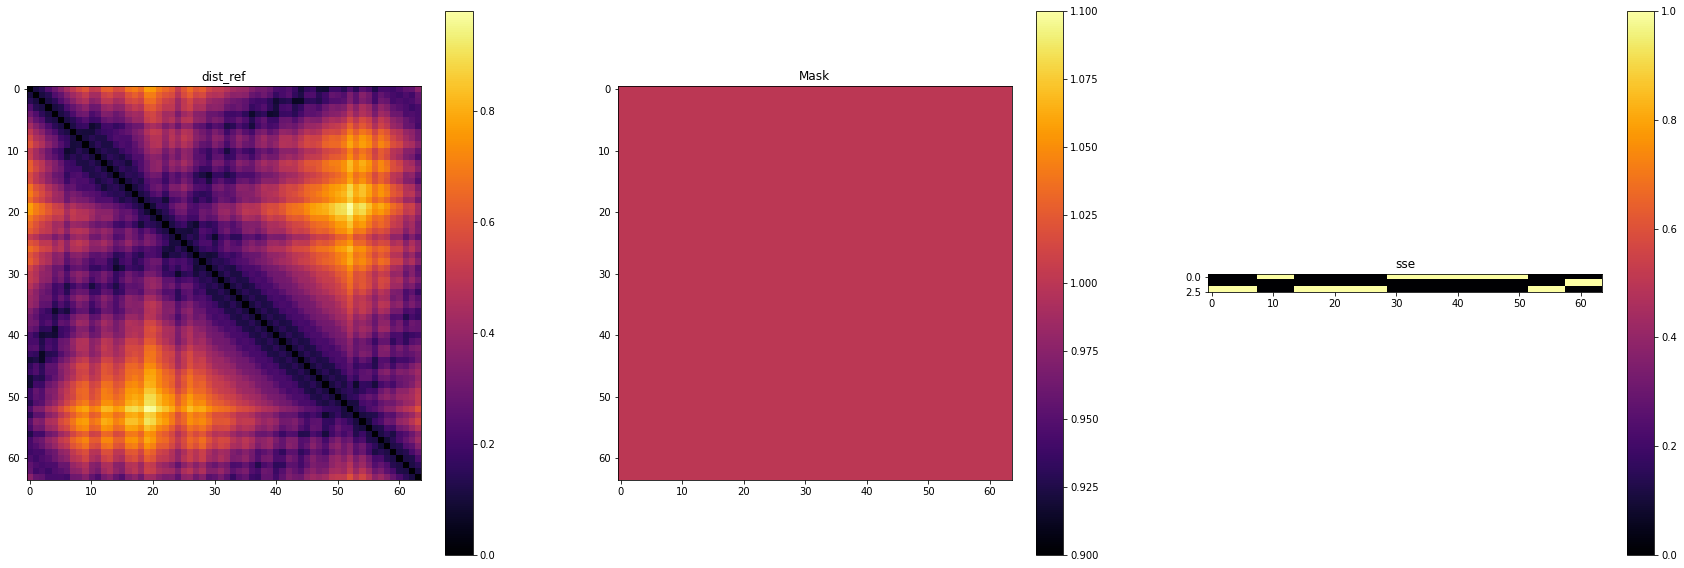

In [49]:
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))

print(dist_ref.shape,mask.shape,sse.shape,ref_len) 
ind = 0
img_list = [dist_ref[ind].squeeze().detach().cpu().numpy(),
           mask[ind].squeeze().detach().cpu().numpy(),
           sse[ind].squeeze().detach().cpu().numpy(),
           ]

title_list = ['dist_ref','Mask','sse']
plot_sub_plots(1,3,img_list,title_list,cmap = 'inferno')
print('')

## Autoencoder Model

In [50]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = 1, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [51]:
enc_path = f'./model_checkpoints/Autoencoder Training Using Distoref/encoder_dist.pth.tar'
encoder = torch.load(enc_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

dec_path = f'./model_checkpoints/Autoencoder Training Using Distoref/decoder_dist.pth.tar'
decoder = torch.load(dec_path).to(device)#CNN_Decoder(lat_chan=32).to(device)#torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

8496
67713


## Encoder for SSE

In [52]:
class CNN_1D_Encoder(nn.Module):
    
    def __init__(self, input_nc=3, ngf = 16):
        super(CNN_1D_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc6 = self.enc_block(in_ch = ngf*16, out_ch = ngf*32, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )

        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.enc5(x)
        x = self.enc6(x)
        return x
    



In [53]:
enc_sse_path = f'./model_checkpoints/Autoencoder Training Using SSE/encoder_sse.pth.tar'
encoder_sse = torch.load(enc_sse_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder_sse.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

8496


## UNet

In [54]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x,label):
        # label = label.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        print(x_ln.shape,label.shape)
        # attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value, _ = self.mha(x_ln, label, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


#Crosss
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def exists(val):
    return val is not None

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads
        
        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


# class UNet(nn.Module):
#     def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
#         super().__init__()
#         self.device = device
#         self.time_dim = time_dim
#         self.inc = DoubleConv(c_in, 64)
#         self.down1 = Down(64, 128)
#         self.sa1 = SelfAttention(128, 4)
#         self.down2 = Down(128, 256)
#         self.sa2 = SelfAttention(256, 2)
#         self.down3 = Down(256, 256)
#         self.sa3 = SelfAttention(256, 1)

#         self.bot1 = DoubleConv(256, 512)
#         self.bot2 = DoubleConv(512, 512)
#         self.bot3 = DoubleConv(512, 256)

#         self.up1 = Up(512, 128)
#         self.sa4 = SelfAttention(128, 2)
#         self.up2 = Up(256, 64)
#         self.sa5 = SelfAttention(64, 4)
#         self.up3 = Up(128, 64)
#         self.sa6 = SelfAttention(64, 8)
#         self.outc = nn.Conv2d(64, c_out, kernel_size=1)

#     def pos_encoding(self, t, channels):
#         inv_freq = 1.0 / (
#             10000
#             ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
#         )
#         pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
#         pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
#         pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
#         return pos_enc

#     def forward(self, x, t):
#         t = t.unsqueeze(-1).type(torch.float)
#         t = self.pos_encoding(t, self.time_dim)

#         x1 = self.inc(x)
#         x2 = self.down1(x1, t)
#         # print(f"x2: {x2.shape}")
#         x2 = self.sa1(x2)
#         x3 = self.down2(x2, t)
#         # print(f"x3: {x3.shape}")
#         x3 = self.sa2(x3)
#         x4 = self.down3(x3, t)
#         # print(f"x4: {x4.shape}")
#         x4 = self.sa3(x4)
        
#         # print(f"x4: {x4.shape}")
#         x4 = self.bot1(x4)
#         x4 = self.bot2(x4)
#         x4 = self.bot3(x4)
        
#         # print(f"x4: {x4.shape}")
#         x = self.up1(x4, x3, t)
#         # print(f"x: {x.shape}")
#         x = self.sa4(x)
#         # print(f"x: {x.shape}")
#         x = self.up2(x, x2, t)
#         x = self.sa5(x)
#         x = self.up3(x, x1, t)
#         x = self.sa6(x)
#         output = self.outc(x)
#         return output
    
    
class UNet_Conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):#,num_classes = None):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = CrossAttention(128, 256)
        self.down2 = Down(128, 256)
        self.sa2 = CrossAttention(256, 256)
        self.down3 = Down(256, 256)
        self.sa3 = CrossAttention(256, 256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = CrossAttention(128, 256)
        self.up2 = Up(256, 64)
        self.sa5 = CrossAttention(64, 256)
        self.up3 = Up(128, 64)
        self.sa6 = CrossAttention(64, 256)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
#         if num_classes is not None:
#             self.label_emb = nn.Embedding(num_classes, time_dim)
        

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t,labels):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        # print(f"t:{t.shape}")
        # if labels!=None:
        #     # print(self.label_emb(labels).shape)
        #     t = t+ labels
        
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = x2.view(-1, 128, 8*8).swapaxes(1, 2)
        # print(f"x2: {x2.shape,labels.shape}")
        x2 = self.sa1(x2,labels).swapaxes(1, 2).view(-1,128,8,8)
        # print(f"x2: {x2.shape}")
        
        
        
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = x3.view(-1, 256, 4*4).swapaxes(1, 2)
        x3 = self.sa2(x3,labels).swapaxes(1, 2).view(-1,256,4,4)
        
        
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = x4.view(-1, 256, 2*2).swapaxes(1, 2)
        x4 = self.sa3(x4,labels).view(-1,256,2,2)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = x.view(-1, 128, 4*4).swapaxes(1, 2)
        # print(x.shape)
        x = self.sa4(x,labels).view(-1,128,4,4)
        
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = x.view(-1, 64, 8*8).swapaxes(1, 2)
        x = self.sa5(x,labels).view(-1,64,8,8)
        
        x = self.up3(x, x1, t)
        x = x.view(-1, 64, 16*16).swapaxes(1, 2)
        x = self.sa6(x,labels).view(-1,64,16,16)
        output = self.outc(x)
        return output

In [55]:
model = UNet_Conditional(c_in=32, c_out=32, time_dim=256, device="cuda").to(device)
# cond_enc = Cond_Encoder().to(device)
#testing
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))
# print(digit_labels.shape)

lat_c = encoder(dist_ref)
t = torch.randint(low=1, high=1000, size=(dist_ref.shape[0],)).to(device)
labels = encoder_sse(sse.squeeze(1))
print(lat_c.shape,t.shape,labels.shape)

denoised_lat_c = model(lat_c,t,labels.swapaxes(1, 2))

print(denoised_lat_c.shape)

torch.Size([32, 32, 16, 16]) torch.Size([32]) torch.Size([32, 256, 1])
torch.Size([32, 32, 16, 16])


## Training

In [56]:
# optimizer = optim.AdamW(list(model.parameters())+list(encoder_sse.parameters()), lr=3e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=[32,16,16], device=device)

In [57]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0
        
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig

In [58]:
def train(model,diffusion,encoder,decoder,encoder_sse,optimizer,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.eval()
    decoder.eval()
    encoder_sse.eval()
    model.train()
    # cond_enc.train()
    train_losses = AverageMeter()
    for batch_idx, (x,m,sse,_ ) in enumerate(data_loader):
        x = encoder(x)
        labels = encoder_sse(sse.squeeze(1))
        
        
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        predicted_noise = model(x_t, t,labels.swapaxes(1, 2))
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      
        train_losses.update(loss.data.item())
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    
    x,m,sse,ref_len   = next(iter(data_loader))
    labels = encoder_sse(sse.squeeze(1))
    print(labels.shape)
    # cond_enc.eval()
    # digit_labels_2 = F.one_hot(digit_labels, num_classes=10).unsqueeze(1).float()
    # cond_vec = cond_enc(digit_labels_2.to(device))
    
    sampled_images = diffusion.sample(model, n=x.shape[0],labels = labels.swapaxes(1, 2))
    sampled_images = decoder(sampled_images.float())
    sampled_images = sampled_images.squeeze().detach().cpu().numpy()
    print(sampled_images.shape)
    sse = sse.squeeze().detach().cpu().numpy()
    x = x.squeeze().detach().cpu().numpy()
    img_list = [sampled_images[0],sse[0],x[0],sampled_images[1],sse[1],x[1],
                sampled_images[2],sse[2],x[2],sampled_images[3],sse[3],x[3],
                sampled_images[4],sse[4],x[4],sampled_images[5],sse[5],x[5],
                sampled_images[6],sse[6],x[6],sampled_images[7],sse[7],x[7],
               ] 
    
    title_list = [ref_len[0].item(),ref_len[0].item(),ref_len[0].item(),ref_len[1].item(),ref_len[1].item(),ref_len[1].item(),
                  ref_len[2].item(),ref_len[2].item(),ref_len[2].item(),ref_len[3].item(),ref_len[3].item(),ref_len[3].item(),
                  ref_len[4].item(),ref_len[4].item(),ref_len[4].item(),ref_len[5].item(),ref_len[5].item(),ref_len[5].item(),
                  ref_len[6].item(),ref_len[6].item(),ref_len[6].item(),ref_len[7].item(),ref_len[7].item(),ref_len[7].item(),]
    
    fig = plot_sub_plots(4,6,img_list,title_list,cmap = 'inferno')
    if is_wandb:
            wandb.log({"examples": wandb.Image(fig)})
    
    return train_losses.avg





    # sampled_images = diffusion.sample(model, n=images.shape[0])
    # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


In [ ]:
best_loss = 10000000
train_loss_list = []
n_epochs = 5000

# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)
# print("Training ", end='')
for epoch_idx in range(n_epochs):
    # print('=', end='')
    
    train_loss = train(model,diffusion,encoder,decoder,encoder_sse,optimizer,train_data_loader,is_wandb=is_wandb)     

    train_loss_list.append(train_loss)
    
    
    print(f"Epoch {epoch_idx+1}: {train_loss} ")
    if (train_loss < best_loss): 
        best_loss = train_loss
        # print("Saving Best Model =======================================>")
        torch.save(model, f'{exp_path}/u_net_diff_best_loss.pth.tar')
        # torch.save(cond_enc, f'{exp_path}/cond_enc_diff.pth.tar')
    if (epoch_idx+1)%10 == 0:
        torch.save(model, f'{exp_path}/u_net_diff_checkpoint.pth.tar')
                       
torch.save(model, f'{exp_path}/u_net_diff_final.pth.tar')    
print('Training Completed')

torch.Size([32, 256, 1])


999it [00:08, 120.15it/s]


(32, 64, 64)
Epoch 1: 1.0070101861062088 
torch.Size([32, 256, 1])


999it [00:08, 120.01it/s]


(32, 64, 64)
Epoch 2: 1.0017369181160036 
torch.Size([32, 256, 1])


999it [00:08, 118.85it/s]


(32, 64, 64)
Epoch 3: 1.000819491661661 
torch.Size([32, 256, 1])


999it [00:08, 121.43it/s]


(32, 64, 64)
Epoch 4: 0.9998964958074616 
torch.Size([32, 256, 1])


999it [00:08, 121.50it/s]


(32, 64, 64)
Epoch 5: 1.0003498361362675 
torch.Size([32, 256, 1])


999it [00:08, 120.27it/s]


(32, 64, 64)
Epoch 6: 0.9999067977191957 
torch.Size([32, 256, 1])


999it [00:08, 119.71it/s]


(32, 64, 64)
Epoch 7: 1.0002147090144273 
torch.Size([32, 256, 1])


999it [00:08, 121.20it/s]


(32, 64, 64)
Epoch 8: 1.0001150742778933 
torch.Size([32, 256, 1])


999it [00:08, 119.98it/s]


(32, 64, 64)
Epoch 9: 1.0002878347063453 
torch.Size([32, 256, 1])


999it [00:08, 118.27it/s]


(32, 64, 64)
Epoch 10: 1.000191067777029 
torch.Size([32, 256, 1])


999it [00:08, 121.69it/s]


(32, 64, 64)
Epoch 11: 1.0002393121641826 
torch.Size([32, 256, 1])


999it [00:08, 120.90it/s]


(32, 64, 64)
Epoch 12: 0.9999268006503097 
torch.Size([32, 256, 1])


999it [00:08, 119.51it/s]


(32, 64, 64)
Epoch 13: 0.9995967532561078 
torch.Size([32, 256, 1])


999it [00:08, 119.10it/s]


(32, 64, 64)
Epoch 14: 0.9996244941300493 
torch.Size([32, 256, 1])


999it [00:08, 121.04it/s]


(32, 64, 64)
Epoch 15: 1.0000578683566272 
torch.Size([32, 256, 1])


999it [00:08, 121.83it/s]


(32, 64, 64)
Epoch 16: 1.0000640444639253 
torch.Size([32, 256, 1])


999it [00:08, 119.39it/s]


(32, 64, 64)
Epoch 17: 0.9999810743138073 
torch.Size([32, 256, 1])


999it [00:08, 119.04it/s]


(32, 64, 64)
Epoch 18: 1.0002737306967013 
torch.Size([32, 256, 1])


999it [00:08, 120.46it/s]


(32, 64, 64)
Epoch 19: 1.0003163116734202 
torch.Size([32, 256, 1])


999it [00:08, 121.80it/s]


(32, 64, 64)
Epoch 20: 1.0003629365587623 
torch.Size([32, 256, 1])


999it [00:08, 119.07it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(32, 64, 64)
Epoch 21: 1.0001222442805282 
torch.Size([32, 256, 1])


999it [00:08, 120.04it/s]


(32, 64, 64)
Epoch 22: 0.9995513035029899 
torch.Size([32, 256, 1])


999it [00:08, 122.41it/s]


(32, 64, 64)
Epoch 23: 0.9999528469108954 
torch.Size([32, 256, 1])


999it [00:08, 120.99it/s]


(32, 64, 64)
Epoch 24: 1.0000614044142933 
torch.Size([32, 256, 1])


999it [00:08, 118.65it/s]


(32, 64, 64)
Epoch 25: 1.0001010429568407 
torch.Size([32, 256, 1])


999it [00:08, 119.51it/s]


(32, 64, 64)
Epoch 26: 1.0000437052269293 
torch.Size([32, 256, 1])


999it [00:08, 120.00it/s]


(32, 64, 64)
Epoch 27: 0.9997736491808077 
torch.Size([32, 256, 1])


999it [00:08, 120.20it/s]


(32, 64, 64)
Epoch 28: 1.0002305464046757 
torch.Size([32, 256, 1])


999it [00:08, 119.27it/s]


(32, 64, 64)
Epoch 29: 1.000104992854886 
torch.Size([32, 256, 1])


999it [00:08, 120.38it/s]


(32, 64, 64)
Epoch 30: 1.0003510374363844 
torch.Size([32, 256, 1])


999it [00:08, 120.48it/s]


(32, 64, 64)
Epoch 31: 0.9998388348556146 
torch.Size([32, 256, 1])


999it [00:08, 120.20it/s]


(32, 64, 64)
Epoch 32: 1.0002057048363415 
torch.Size([32, 256, 1])


999it [00:08, 118.91it/s]


(32, 64, 64)
Epoch 33: 1.0003832932410202 
torch.Size([32, 256, 1])


999it [00:08, 122.16it/s]


(32, 64, 64)
Epoch 34: 1.0000948372895155 
torch.Size([32, 256, 1])


999it [00:08, 122.73it/s]


(32, 64, 64)
Epoch 35: 1.000098653440553 
torch.Size([32, 256, 1])


999it [00:08, 118.91it/s]


(32, 64, 64)
Epoch 36: 1.00005906626461 
torch.Size([32, 256, 1])


999it [00:08, 121.10it/s]


(32, 64, 64)
Epoch 37: 1.0000672180478165 
torch.Size([32, 256, 1])


999it [00:08, 121.49it/s]


(32, 64, 64)
Epoch 38: 1.000157351416301 
torch.Size([32, 256, 1])


999it [00:08, 120.38it/s]


(32, 64, 64)
Epoch 39: 0.9999801128860412 
torch.Size([32, 256, 1])


999it [00:08, 119.03it/s]


(32, 64, 64)
Epoch 40: 0.9998610727186126 
torch.Size([32, 256, 1])


999it [00:08, 121.17it/s]


(32, 64, 64)
Epoch 41: 1.0003691213886912 
torch.Size([32, 256, 1])


999it [00:08, 120.96it/s]


(32, 64, 64)
Epoch 42: 1.0003244329274186 
torch.Size([32, 256, 1])


999it [00:08, 118.17it/s]


(32, 64, 64)
Epoch 43: 1.000133781413722 
torch.Size([32, 256, 1])


999it [00:08, 120.00it/s]


(32, 64, 64)
Epoch 44: 0.9999812371362515 
torch.Size([32, 256, 1])


999it [00:08, 121.72it/s]


(32, 64, 64)
Epoch 45: 1.0000615997043083 
torch.Size([32, 256, 1])


999it [00:08, 120.03it/s]


(32, 64, 64)
Epoch 46: 0.9996993890622767 
torch.Size([32, 256, 1])


999it [00:08, 119.70it/s]


(32, 64, 64)
Epoch 50: 1.0002600991629003 
torch.Size([32, 256, 1])


999it [00:08, 118.96it/s]


(32, 64, 64)
Epoch 51: 1.000132817078412 
torch.Size([32, 256, 1])


999it [00:08, 120.09it/s]


(32, 64, 64)
Epoch 52: 0.9992720639802576 
torch.Size([32, 256, 1])


999it [00:08, 121.36it/s]


(32, 64, 64)
Epoch 53: 1.000214213762826 
torch.Size([32, 256, 1])


999it [00:08, 119.50it/s]


(32, 64, 64)
Epoch 54: 0.999968528262968 
torch.Size([32, 256, 1])


999it [00:08, 118.75it/s]


(32, 64, 64)
Epoch 55: 1.0001203505004324 
torch.Size([32, 256, 1])


999it [00:08, 120.48it/s]


(32, 64, 64)
Epoch 56: 0.999795565275642 
torch.Size([32, 256, 1])


999it [00:08, 121.20it/s]


(32, 64, 64)
Epoch 57: 1.0000005345034406 
torch.Size([32, 256, 1])


999it [00:08, 119.39it/s]


(32, 64, 64)
Epoch 58: 0.9996572519705548 
torch.Size([32, 256, 1])


999it [00:08, 118.42it/s]


(32, 64, 64)
Epoch 59: 1.0001092819663566 
torch.Size([32, 256, 1])


999it [00:08, 120.64it/s]


(32, 64, 64)
Epoch 60: 0.999907426233214 
torch.Size([32, 256, 1])


999it [00:08, 122.00it/s]


(32, 64, 64)
Epoch 61: 1.0001312552428827 
torch.Size([32, 256, 1])


999it [00:08, 120.97it/s]


(32, 64, 64)
Epoch 62: 0.9998409738385581 
torch.Size([32, 256, 1])


999it [00:08, 118.60it/s]


(32, 64, 64)
Epoch 63: 1.000161857624364 
torch.Size([32, 256, 1])


999it [00:08, 121.20it/s]


(32, 64, 64)
Epoch 64: 1.0000297514403738 
torch.Size([32, 256, 1])


999it [00:08, 120.92it/s]


(32, 64, 64)
Epoch 65: 0.9998198902703882 
torch.Size([32, 256, 1])


999it [00:08, 119.00it/s]


(32, 64, 64)
Epoch 66: 0.9999228652899828 
torch.Size([32, 256, 1])


999it [00:08, 119.61it/s]


(32, 64, 64)
Epoch 67: 0.9999901565109811 
torch.Size([32, 256, 1])


999it [00:08, 117.00it/s]


(32, 64, 64)
Epoch 68: 1.0002087354660034 
torch.Size([32, 256, 1])


999it [00:08, 119.42it/s]


(32, 64, 64)
Epoch 69: 1.0001152177167132 
torch.Size([32, 256, 1])


999it [00:08, 119.50it/s]


(32, 64, 64)
Epoch 70: 1.0001835866672237 
torch.Size([32, 256, 1])


999it [00:08, 120.56it/s]


(32, 64, 64)
Epoch 71: 1.0000039702508507 
torch.Size([32, 256, 1])


999it [00:08, 120.70it/s]


(32, 64, 64)
Epoch 72: 1.0003902800684052 
torch.Size([32, 256, 1])


999it [00:08, 118.53it/s]


(32, 64, 64)
Epoch 73: 1.0003828963613122 
torch.Size([32, 256, 1])


999it [00:08, 120.21it/s]


(32, 64, 64)
Epoch 74: 0.9998536420062305 
torch.Size([32, 256, 1])


999it [00:08, 121.06it/s]


(32, 64, 64)
Epoch 75: 1.0005621934324744 
torch.Size([32, 256, 1])


999it [00:08, 120.77it/s]


(32, 64, 64)
Epoch 76: 0.9998471116631981 
torch.Size([32, 256, 1])


999it [00:08, 119.18it/s]


(32, 64, 64)
Epoch 77: 0.9996878650130295 
torch.Size([32, 256, 1])


999it [00:08, 121.36it/s]


(32, 64, 64)
Epoch 78: 1.000436659266309 
torch.Size([32, 256, 1])


999it [00:08, 121.30it/s]


(32, 64, 64)
Epoch 79: 0.9999209177203294 
torch.Size([32, 256, 1])


999it [00:08, 119.65it/s]


(32, 64, 64)
Epoch 80: 1.000040662482502 
torch.Size([32, 256, 1])


999it [00:08, 119.13it/s]


(32, 64, 64)
Epoch 81: 0.9994783740702683 
torch.Size([32, 256, 1])


999it [00:08, 121.21it/s]


(32, 64, 64)
Epoch 82: 0.9998433037502009 
torch.Size([32, 256, 1])


999it [00:08, 121.57it/s]


(32, 64, 64)
Epoch 83: 1.0000635051145785 
torch.Size([32, 256, 1])


999it [00:08, 119.25it/s]


(32, 64, 64)
Epoch 84: 1.0002532577126977 
torch.Size([32, 256, 1])


778it [00:06, 119.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

492it [00:04, 122.98it/s]

torch.Size([32, 256, 1])


999it [00:08, 122.20it/s]


(32, 64, 64)
Epoch 198: 0.9998011215915524 
torch.Size([32, 256, 1])


999it [00:08, 122.18it/s]


(32, 64, 64)
Epoch 199: 1.0003097837533408 
torch.Size([32, 256, 1])


999it [00:08, 119.29it/s]


(32, 64, 64)
Epoch 200: 0.9996581673622131 
torch.Size([32, 256, 1])


999it [00:08, 119.33it/s]


(32, 64, 64)
Epoch 201: 1.0001601082522695 
torch.Size([32, 256, 1])


999it [00:08, 119.96it/s]


(32, 64, 64)
Epoch 202: 0.9998007668712274 
torch.Size([32, 256, 1])


999it [00:08, 121.33it/s]


(32, 64, 64)
Epoch 203: 0.9997846537489232 
torch.Size([32, 256, 1])


999it [00:08, 118.81it/s]


(32, 64, 64)
Epoch 204: 0.999905515492447 
torch.Size([32, 256, 1])


999it [00:08, 120.30it/s]


(32, 64, 64)
Epoch 205: 1.0002257823944092 
torch.Size([32, 256, 1])


999it [00:08, 121.30it/s]


(32, 64, 64)
Epoch 206: 0.9998489618301392 
torch.Size([32, 256, 1])


999it [00:08, 120.29it/s]


(32, 64, 64)
Epoch 207: 1.0004105398325416 
torch.Size([32, 256, 1])


999it [00:08, 119.79it/s]


(32, 64, 64)
Epoch 208: 0.9999302368823105 
torch.Size([32, 256, 1])


999it [00:08, 120.38it/s]


(32, 64, 64)
Epoch 209: 1.0004250024392354 
torch.Size([32, 256, 1])


999it [00:08, 121.05it/s]


(32, 64, 64)
Epoch 210: 1.0001720689176543 
torch.Size([32, 256, 1])


999it [00:08, 119.86it/s]


(32, 64, 64)
Epoch 211: 1.000016433436696 
torch.Size([32, 256, 1])


999it [00:08, 119.07it/s]


(32, 64, 64)
Epoch 212: 0.9999237545137483 
torch.Size([32, 256, 1])


999it [00:08, 120.79it/s]


(32, 64, 64)
Epoch 213: 1.0003491431716982 
torch.Size([32, 256, 1])


999it [00:08, 120.98it/s]


(32, 64, 64)
Epoch 214: 0.9997006267066894 
torch.Size([32, 256, 1])


999it [00:08, 118.78it/s]


(32, 64, 64)
Epoch 215: 1.0001785803616532 
torch.Size([32, 256, 1])


999it [00:08, 120.22it/s]


(32, 64, 64)
Epoch 216: 0.9997055409400444 
torch.Size([32, 256, 1])


999it [00:08, 121.77it/s]


(32, 64, 64)
Epoch 217: 1.0001501092096654 
torch.Size([32, 256, 1])


999it [00:08, 119.28it/s]


(32, 64, 64)
Epoch 218: 0.9996419771900021 
torch.Size([32, 256, 1])


999it [00:08, 119.17it/s]


(32, 64, 64)
Epoch 219: 1.0003134671265517 
torch.Size([32, 256, 1])


999it [00:08, 121.17it/s]


(32, 64, 64)
Epoch 220: 1.0001105171878164 
torch.Size([32, 256, 1])


999it [00:08, 119.13it/s]


(32, 64, 64)
Epoch 221: 0.999850566309642 
torch.Size([32, 256, 1])


999it [00:08, 121.76it/s]


(32, 64, 64)
Epoch 222: 1.0002148102938644 
torch.Size([32, 256, 1])


999it [00:08, 121.31it/s]


(32, 64, 64)
Epoch 223: 0.9995892774767992 
torch.Size([32, 256, 1])


999it [00:08, 119.43it/s]


(32, 64, 64)
Epoch 224: 0.9998590592446366 
torch.Size([32, 256, 1])


999it [00:08, 119.74it/s]


(32, 64, 64)
Epoch 225: 0.9996121176859227 
torch.Size([32, 256, 1])


999it [00:08, 121.09it/s]


(32, 64, 64)
Epoch 226: 0.9998937535092114 
torch.Size([32, 256, 1])


999it [00:08, 121.23it/s]


(32, 64, 64)
Epoch 227: 1.0000061891912444 
torch.Size([32, 256, 1])


999it [00:08, 118.37it/s]


(32, 64, 64)
Epoch 228: 1.0000933990245913 
torch.Size([32, 256, 1])


999it [00:08, 121.06it/s]


(32, 64, 64)
Epoch 229: 0.9998220205307007 
torch.Size([32, 256, 1])


999it [00:08, 121.42it/s]


(32, 64, 64)
Epoch 230: 0.9996865760020124 
torch.Size([32, 256, 1])


999it [00:08, 119.92it/s]


(32, 64, 64)
Epoch 231: 1.000342466482302 
torch.Size([32, 256, 1])


999it [00:08, 119.42it/s]


(32, 64, 64)
Epoch 232: 0.9996921076038019 
torch.Size([32, 256, 1])


823it [00:06, 122.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 119.47it/s]


(32, 64, 64)
Epoch 397: 1.0002595990653929 
torch.Size([32, 256, 1])


999it [00:08, 120.19it/s]


(32, 64, 64)
Epoch 488: 0.9997567931811014 
torch.Size([32, 256, 1])


999it [00:08, 120.12it/s]


(32, 64, 64)
Epoch 489: 0.9997967326544165 
torch.Size([32, 256, 1])


999it [00:08, 121.32it/s]


(32, 64, 64)
Epoch 490: 0.9999566155720533 
torch.Size([32, 256, 1])


999it [00:08, 120.66it/s]


(32, 64, 64)
Epoch 491: 1.0002174639120334 
torch.Size([32, 256, 1])


999it [00:08, 118.70it/s]


(32, 64, 64)
Epoch 492: 1.0001702890163515 
torch.Size([32, 256, 1])


999it [00:08, 121.02it/s]


(32, 64, 64)
Epoch 493: 1.0001635309157333 
torch.Size([32, 256, 1])


999it [00:08, 121.49it/s]


(32, 64, 64)
Epoch 494: 1.0000125586501951 
torch.Size([32, 256, 1])


999it [00:08, 120.37it/s]


(32, 64, 64)
Epoch 495: 0.9997852590025925 
torch.Size([32, 256, 1])


999it [00:08, 119.66it/s]


(32, 64, 64)
Epoch 496: 0.9997376518520883 
torch.Size([32, 256, 1])


999it [00:08, 121.65it/s]


(32, 64, 64)
Epoch 497: 0.9999120855719094 
torch.Size([32, 256, 1])


999it [00:08, 120.88it/s]


(32, 64, 64)
Epoch 498: 0.9997649454488987 
torch.Size([32, 256, 1])


999it [00:08, 119.68it/s]


(32, 64, 64)
Epoch 499: 0.9995653663224321 
torch.Size([32, 256, 1])


999it [00:08, 118.89it/s]


(32, 64, 64)
Epoch 500: 1.0003300047502286 
torch.Size([32, 256, 1])


999it [00:08, 121.19it/s]


(32, 64, 64)
Epoch 501: 1.0001687485028088 
torch.Size([32, 256, 1])


999it [00:08, 120.99it/s]


(32, 64, 64)
Epoch 502: 1.0002438750693468 
torch.Size([32, 256, 1])


999it [00:08, 118.96it/s]


(32, 64, 64)
Epoch 503: 1.000053407700081 
torch.Size([32, 256, 1])


999it [00:08, 120.65it/s]


(32, 64, 64)
Epoch 504: 1.0005405385319779 
torch.Size([32, 256, 1])


999it [00:08, 118.46it/s]


(32, 64, 64)
Epoch 505: 1.0001526949851494 
torch.Size([32, 256, 1])


999it [00:08, 120.79it/s]


(32, 64, 64)
Epoch 506: 0.9997970011176133 
torch.Size([32, 256, 1])


999it [00:08, 119.27it/s]


(32, 64, 64)
Epoch 507: 0.9999208183792548 
torch.Size([32, 256, 1])


999it [00:08, 121.23it/s]


(32, 64, 64)
Epoch 508: 1.0001385759531967 
torch.Size([32, 256, 1])


999it [00:08, 121.39it/s]


(32, 64, 64)
Epoch 509: 0.9996419844588613 
torch.Size([32, 256, 1])


999it [00:08, 118.33it/s]


(32, 64, 64)
Epoch 510: 1.0000568623465251 
torch.Size([32, 256, 1])


999it [00:08, 119.41it/s]


(32, 64, 64)
Epoch 511: 0.9998572115006485 
torch.Size([32, 256, 1])


999it [00:08, 121.06it/s]


(32, 64, 64)
Epoch 512: 0.9998668388622564 
torch.Size([32, 256, 1])


999it [00:08, 121.70it/s]


(32, 64, 64)
Epoch 513: 1.0001713807989911 
torch.Size([32, 256, 1])


999it [00:08, 118.40it/s]


(32, 64, 64)
Epoch 514: 1.000264729426159 
torch.Size([32, 256, 1])


999it [00:08, 121.11it/s]


(32, 64, 64)
Epoch 515: 0.9996211145951496 
torch.Size([32, 256, 1])


999it [00:08, 121.72it/s]


(32, 64, 64)
Epoch 516: 1.0000237347633858 
torch.Size([32, 256, 1])


999it [00:08, 120.66it/s]


(32, 64, 64)
Epoch 517: 1.0000670954463928 
torch.Size([32, 256, 1])


999it [00:08, 118.52it/s]


(32, 64, 64)
Epoch 518: 1.0001289292079647 
torch.Size([32, 256, 1])


999it [00:08, 119.89it/s]


(32, 64, 64)
Epoch 519: 0.9999036721097745 
torch.Size([32, 256, 1])


999it [00:08, 121.23it/s]


(32, 64, 64)
Epoch 520: 0.9999673138789045 
torch.Size([32, 256, 1])


999it [00:08, 118.42it/s]


(32, 64, 64)
Epoch 521: 0.9999693394676457 
torch.Size([32, 256, 1])


999it [00:08, 116.76it/s]


(32, 64, 64)
Epoch 522: 0.9995571379739094 
torch.Size([32, 256, 1])


889it [00:07, 121.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([32, 256, 1])


999it [00:08, 119.94it/s]


(32, 64, 64)
Epoch 527: 1.0000901614747397 
torch.Size([32, 256, 1])


999it [00:08, 120.85it/s]


(32, 64, 64)
Epoch 528: 1.000302661725176 
torch.Size([32, 256, 1])


999it [00:08, 117.23it/s]


(32, 64, 64)
Epoch 529: 0.999919892326603 
torch.Size([32, 256, 1])


999it [00:08, 115.47it/s]


(32, 64, 64)
Epoch 530: 1.0000538176637355 
torch.Size([32, 256, 1])


999it [00:08, 120.34it/s]


(32, 64, 64)
Epoch 531: 0.9999748739769788 
torch.Size([32, 256, 1])


999it [00:08, 122.14it/s]


(32, 64, 64)
Epoch 532: 1.0005544075151769 
torch.Size([32, 256, 1])


999it [00:08, 117.31it/s]


(32, 64, 64)
Epoch 533: 1.000094269349323 
torch.Size([32, 256, 1])


999it [00:08, 115.70it/s]


(32, 64, 64)
Epoch 534: 1.0000026904470551 
torch.Size([32, 256, 1])


999it [00:08, 119.77it/s]


(32, 64, 64)
Epoch 535: 1.0002175976590413 
torch.Size([32, 256, 1])


999it [00:08, 120.48it/s]


(32, 64, 64)
Epoch 536: 0.9994802591277332 
torch.Size([32, 256, 1])


999it [00:08, 117.53it/s]


(32, 64, 64)
Epoch 537: 0.9997778525197409 
torch.Size([32, 256, 1])


999it [00:08, 117.15it/s]


(32, 64, 64)
Epoch 538: 1.0002111739259425 
torch.Size([32, 256, 1])


999it [00:08, 115.76it/s]


(32, 64, 64)
Epoch 539: 0.9998778070860762 
torch.Size([32, 256, 1])


999it [00:08, 121.37it/s]


(32, 64, 64)
Epoch 540: 0.9996400170209931 
torch.Size([32, 256, 1])


999it [00:08, 120.40it/s]


(32, 64, 64)
Epoch 541: 1.0002346499179438 
torch.Size([32, 256, 1])


999it [00:08, 112.94it/s]


(32, 64, 64)
Epoch 542: 1.000148463539961 
torch.Size([32, 256, 1])


999it [00:08, 116.00it/s]


(32, 64, 64)
Epoch 543: 1.0005066419035438 
torch.Size([32, 256, 1])


999it [00:08, 119.66it/s]


(32, 64, 64)
Epoch 544: 0.9998686924213316 
torch.Size([32, 256, 1])


798it [00:06, 123.10it/s]